<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/6_advanced_adaptation_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アドバンストな共分散行列の適応方法

これまでの議論では理解を簡単にするために，rank-$\mu$ update と呼ばれる，著者が最も簡単に理解できるであろうと考える共分散行列の更新方法のみに着目してアルゴリズムを紹介してきた．

最新のCMA-ES（dd-CMA-ES[1]）では，rank-one update[2]，rank-$\mu$ update[3]，active update[4]，diagonal acceleration[1]を組み合わせることで，より効率的な共分散行列の学習を可能としている．これまでに紹介してきた rank-$\mu$ updateを基準にした場合，それぞれのコンポーネントには以下のような利点がある：

* rank-one update：集団サイズが小さい場合に効率的．共分散行列のうち，固有値の大きな成分を学習する際に効率的．

* active update：共分散行列のうち，固有値の小さな成分を学習する際に効率的．

* diagonal acceleration：共分散行列の対角成分（分散行列）を学習する際に効率的．

ここでは，それぞれのコンポーネントについて紹介していく．

[1] Y. Akimoto, N. Hansen; Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies. Evol Comput 2020; 28 (3): 405–435. doi: https://doi.org/10.1162/evco_a_00260

[2] N. Hansen and A. Ostermeier, "Completely Derandomized Self-Adaptation in Evolution Strategies," in Evolutionary Computation, vol. 9, no. 2, pp. 159-195, June 2001, doi: 10.1162/106365601750190398.

[3] Hansen N, Müller SD, Koumoutsakos P. Reducing the time complexity of the derandomized evolution strategy with covariance matrix adaptation (CMA-ES). Evol Comput. 2003 Spring;11(1):1-18. doi: 10.1162/106365603321828970. PMID: 12804094.

[4] G. A. Jastrebski and D. V. Arnold, "Improving Evolution Strategies through Active Covariance Matrix Adaptation," 2006 IEEE International Conference on Evolutionary Computation, Vancouver, BC, Canada, 2006, pp. 2814-2821, doi: 10.1109/CEC.2006.1688662.

## dd-CMA-ES のコード

以下で説明する更新方法を全て含むdd-CMA-ESのコードを以下に示す．
なお，dd-CMA-ESのコード（リスタート戦略や制約対処を含む）は以下にて公開されているので，こちらを参照されたい．

* https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518
* https://github.com/akimotolab/multi-fidelity

In [1]:
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]
    Note
    ----
    If you are interested in constrained optimization and/or multi-fidelity optimization,
    check the following repository:
    https://github.com/akimotolab/multi-fidelity
    
    History
    -------
    2022/03/24: Mirroring box constraint handling and periodic variable handling [3] have been implemented.
    2020/06/10: Restart (IPOP mechanism) [2] has been implemented.
    2019/03/23: release
    Reference
    ---------
    [1] Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
    [2] A. Auger and N. Hansen.
    A Restart CMA Evolution Strategy With Increasing Population Size
    IEEE Congress on Evolutionary Computation (2005): 1769-1776.
    [3] Y. Yamaguchi and A. Akimoto.
    A Note on the CMA-ES for Functions with Periodic Variables
    Genetic and Evolutionary Computation Conference Companion (2018): 227-228.
    """
    
    def __init__(self, xmean0, sigma0, 
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 flg_force_correlation=None,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        flg_force_correlation : bool or None, optional (default = None)
            force C to be a correlation matrix if True
            None : flg_force_correlation = flg_variance_update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.flg_force_correlation = flg_variance_update if flg_force_correlation is None else flg_force_correlation
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh
        
        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N)) 
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)
        
        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others 
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.
        
        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]
        
        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation        
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy 
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)            

            # force C to be correlation matrix
            if self.flg_force_correlation:
                cd = np.sqrt(np.diag(self.C))
                self.D *= cd
                self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)            
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)
        
        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx
        
    def upper_bounding_coordinate_std(self, coordinate_length):
        """Upper-bounding coordinate-wise standard deviation
        
        When some design variables are periodic, the coordinate-wise standard deviation 
        should be upper-bounded by r_i / 4, where r_i is the period of the ith variable.
        The correction of the overall covariance matrix, Sigma, is done as follows:
            Sigma = Correction * Sigma * Correction,
        where Correction is a diagonal matrix defined as
            Correction_i = min( r_i / (4 * Sigma_{i,i}^{1/2}), 1 ).
            
        In DD-CMA, the correction matrix is simply multiplied to D.
            
        For example, if a mirroring box constraint handling is used for a box constraint
        [l_i, u_i], the variables become periodic on [l_i - (u_i-l_i)/2, u_i + (u_i-l_i)/2]. 
        Therefore, the period is 
            r_i = 2 * (u_i - l_i).
        
        Parameters
        ----------
        coordinate_length : ndarray (1D) or float
            coordinate-wise search length r_i.
            
        References
        ----------
        T. Yamaguchi and Y. Akimoto. 
        A Note on the CMA-ES for Functions with Periodic Variables.
        GECCO '18 Companion, pages 227--228 (2018)
        """
        correction = np.fmin(coordinate_length / self.coordinate_std / 4.0, 1)
        self.D *= correction
        
        
    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''
    

class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")
                
    def __call__(self, condition=''):
        self.log(condition)
        
    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)  
            for i in key_split:
                var = getattr(var, i)  
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if self.latexmode:
            if "e" in float_str:
                base, exponent = float_str.split("e")
                return r"{0}e{1}".format(base, int(exponent))
            else:
                return r"" + float_str + ""
        else:
            if "e" in float_str:
                base, exponent = float_str.split("e")
                return "{0}e{1}".format(base, int(exponent))
            else:
                return "" + float_str + ""
        
    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral',
             latexmode=False):
        
        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        latexmode : bool, optional (default = False)
            LaTeX is enabled if this is True
        
        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        self.latexmode = latexmode 

        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        if self.latexmode:
            mpl.rc('text', usetex=True)  # for a paper submision
            mpl.rc('ps', useafm=True)  # Force to use
            mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()
        
        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            if self.latexmode:
                ax.set_title(r'\detokenize{' + key + '}')
            else:
                ax.set_title(key)
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables
            
    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])  
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])     
    return zz

10 100 717275075.2877443 717275075.2877443
20 200 184807347.19195518 184807347.19195518
30 300 17916515.967837613 17023289.635849472
40 400 4045074.732552721 4045074.732552721
50 500 3044809.105779871 3044809.105779871
60 600 1716869.8821696993 1716869.8821696993
70 700 626265.6956908135 626265.6956908135
80 800 285713.23651353456 253805.60292031057
90 900 145125.03393842373 138555.33146189153
100 1000 52202.8683951078 51104.12647223566
110 1100 13201.82410260383 13201.82410260383
120 1200 3142.3417838867754 2664.7908941349015
130 1300 1007.772506441921 818.4264088924974
140 1400 497.0999723561108 497.0999723561108
150 1500 474.06971304118633 474.06971304118633
160 1600 466.4075890276581 466.08045478444546
170 1700 464.53011907916516 464.53011907916516
180 1800 462.20884702540934 462.20884702540934
190 1900 460.19608928170055 460.0273946085945
200 2000 451.9741829978302 451.9741829978302
210 2100 428.64656499866396 428.64656499866396
220 2200 354.11408075364307 354.11408075364307
230 2

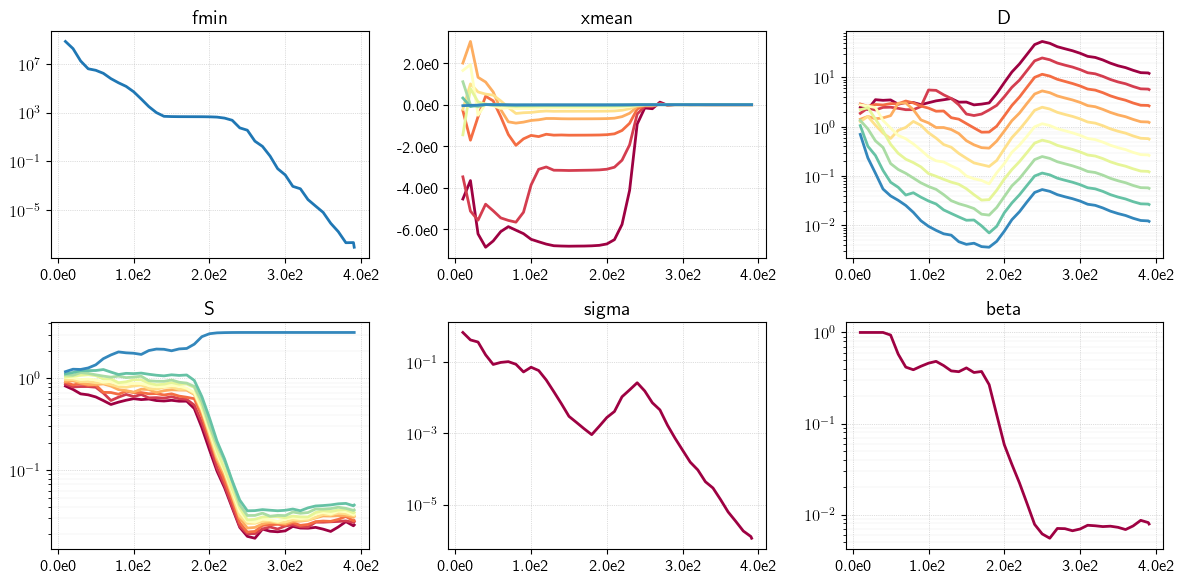

In [ ]:
N = 10

# Ellipsoid-Cigar function
def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

def fobj(x):
    return ellcig(x)

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### 共分散行列の表現

以下，解生成分布の共分散行列$\Sigma$を
$$
\Sigma = \sigma^2 D C D
$$
と表現することにする．
$\sigma^2$はステップサイズであり，これまで通りCSAによって更新されるものとする．$D$は対角行列であり，$\sigma^2 D^2$が$\Sigma$の分散行列に対応する．すなわち，$\sigma [D]_{i,i}$が$i$番目の要素の標準偏差に対応する．$C$は対角成分が$1$となる行列であり，$\Sigma$の相関行列に対応する．Separable-CMAでは，$C = I$と固定し，$D$を更新していたと解釈できる．また，CMAでは$DCD$をまとめて更新していたと解釈できる．Diagonal accelerationでは，$D$と$C$を別々に更新することで効率的な学習を可能としている．以下ではこの分解を前提に，話を進めていく．

この共分散行列を用いた場合の解生成は以下の手順で行うことができる．
1. $z_i \sim \mathcal{N}(0, I)$
2. $y_i = \sqrt{C} z_i$
3. $x_i = m + \sigma D y_i$

#### Rank-$\mu$ update を用いた場合の更新式

通常のCMA-ES（$C$を更新する方法）とSeparable-CMA-ES（$D$を更新する方法）において，これまでに紹介してきたRank-$\mu$ updateを用いる場合の更新式をここに示す．Separable-CMA-ESの場合には，$D^2$を更新していくことになるが，ここではその変種として，$D$を更新していくバリエーションを考える．これは文献[1]で示されている方法である．

まず，$D$が固定されており（必ずしも$D = I$でなくてもよい），$C$のみを更新する場合，更新式は
$$
C \leftarrow C + c_\mu \sum_{i=1}^{\lambda} w_{i}\left( y_{i:\lambda}y_{i:\lambda}^\mathrm{T} - C \right)
$$
となる．ここで，rank-$\mu$ update を考える場合には，$w_1 \geq \dots \geq w_\lambda \geq 0$であり，$\sum_{i=1}^{\lambda} w_i = 1$を仮定していたことに注意されたい．

次に，$C = I$が固定されている場合の$D$の更新式は，
$$
\log D^2 \leftarrow \log D^2 + c_{\mu,D} \sum_{i=1}^{\lambda} w_{i}\mathrm{diag}\left( z_{i:\lambda}z_{i:\lambda}^\mathrm{T} - I \right)
$$
と表すことができる．指数関数を一次近似すれば，これまでに紹介したSeparable-CMAの更新式と対応していることが分かる．



## Rank-one update

まず，直感的な説明をする．Rank-$\mu$ update が各イテレーションでの$w_i > 0$となる$\mu$個の解の情報を活用して共分散行列を更新しているのに対し，rank-one update では複数イテレーションを通した解候補の情報を活用することを目的とする．そのため，$\mu$が小さい場合には，rank-one updateの方が情報をより効率的に活用できるようになる．また，rank-one updateではrank-$\mu$ updateでは活用できない符号情報を活用することが可能になる．これについては後述する．

更新式を見ていく．Rank-one update ではCSAでも利用されている進化パスを利用する．ただし，目的が異なるため，進化パスの定義が異なり，
$$
p_C \leftarrow (1 - c_C) p_C + \sqrt{\frac{c_C (2 - c_C)}{\sum_{j=1}^{\lambda} w_j^2} } \sum_{i=1}^{\lambda} w_i y_{i:\lambda}
$$
となる．
Separable-CMA-ESの場合，
$$
p_D \leftarrow (1 - c_D) p_D + \sqrt{\frac{c_D (2 - c_D)}{\sum_{j=1}^{\lambda} w_j^2} } \sum_{i=1}^{\lambda} w_i z_{i:\lambda}
$$
となり，こちらはCSAで利用されている進化パスと用いている累積率$c_D$が異なる点を除いて等しくなる．
これを用いて，$C$や$D$の更新式に，以下の要素を追加する：
$$
c_{1} (p_C p_C^\mathrm{T} - C) \\
c_{1,D} \mathrm{diag}(p_D p_D^\mathrm{T} - I)
$$

この更新式が不偏性を持つ，すなわち，追加した項がランダム関数のもとで期待値0となることは，CSAにおける不偏性の議論と同様にして導かれる．仮にランダムではなく，イテレーションを通して特定の方向の解が選択され続けているような場合，進化パスはそのような方向に対して大きくなるため，その方向への固有値が大きくなることが期待される．

先に述べた，符号情報を活用できる，というのは以下のようなことを意味する．ある解$y_1 = y$と$y_2 = -y$が与えられたとき，rank-$\mu$ updateでは
$$
w_1 (y_1 y_1^\mathrm{T} - C) + w_2 (y_2 y_2^\mathrm{T} - C) = (w_1 + w_2) (y y^\mathrm{T} - C)
$$
であり，$y_1 = y$と$y_2 = y$の場合にも
$$
w_1 (y_1 y_1^\mathrm{T} - C) + w_2 (y_2 y_2^\mathrm{T} - C) = (w_1 + w_2) (y y^\mathrm{T} - C)
$$
である．いずれの場合も，$y$方向に共分散行列の固有値を大きくする影響を持つ．
一方，rank-one updateでは，$y_1 = y$と$y_2 = -y$が与えられたとき，これらがまず進化パスとして累積されるため，この両者の情報は打ち消しあう．そのため，$y$方向に共分散行列の固有値を大きくする影響は持たない．他方，$y_1 = y$と$y_2 = y$が与えられた場合，進化パスが$y$方向に大きくなり，結果として共分散行列を$y$方向に大きくするような影響がある．

#### 検証実験

$d/2$-tablet関数で実験（半分の変数は残り半分の変数よりも目的関数に与える影響が大きい関数）

* Rank-$\mu$ update with/without rank-one update で比較．デフォルトの集団サイズの場合，共分散行列の学習効率や振る舞いに大きな違いが現れることを確認
* lam（集団サイズ）が大きい場合，rank-$\mu$ update がメインになるため，rank-one updateの有無では大きな差は生じないことを確認（各自確認すること）


#### Rank-$\mu$ update のみ

10 120 6480825.688433793 6070517.470289675
20 240 6155367.389841621 4145239.6796635897
30 360 2055397.2561777316 1391000.184728963
40 480 510341.61357066804 475000.284278322
50 600 259839.30209869353 205435.58983788278
60 720 212557.77729732657 154979.0801508848
70 840 39963.06169553601 39963.06169553601
80 960 42672.52354913085 27587.53209889709
90 1080 20656.69418371725 17472.06426484257
100 1200 8272.65418204521 4463.152774923222
110 1320 5348.918037773221 1888.4618110487813
120 1440 1293.9801804855324 1293.9801804855324
130 1560 554.8266578178095 554.8266578178095
140 1680 510.7683824722348 371.99645584218115
150 1800 279.50290795033976 248.55509429092336
160 1920 210.6652609088488 210.6652609088488
170 2040 168.2528282267431 163.14894230798424
180 2160 157.20853152036574 155.95279736301362
190 2280 153.00274859816363 152.5331951783944
200 2400 152.4235329824017 151.63431439615073
210 2520 152.24058776669833 150.95341893819764
220 2640 151.08853112989712 150.8690799032064
230 2760 

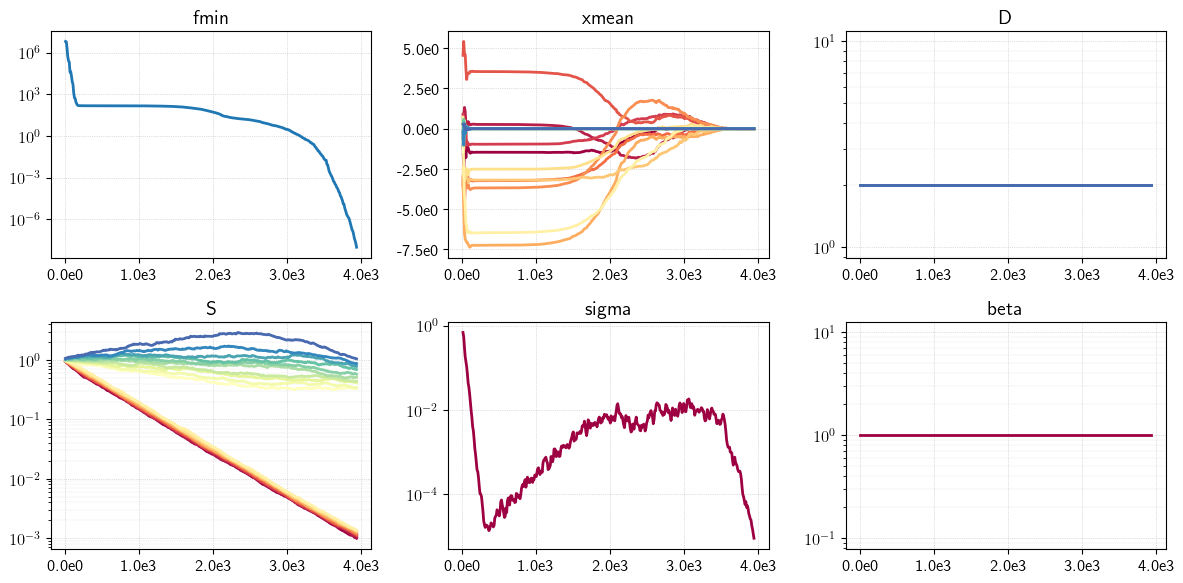

In [ ]:
N = 20

def fobj(x):
    k = x.shape[1] // 2
    f = np.sum(x[:, :k] ** 2, axis=1) + 1e6 * np.sum(x[:, k:] ** 2, axis=1)
    return f

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), 
              sigma0=np.ones(N)*2.,
              lam=None,
              flg_covariance_update=True,
              flg_variance_update=False,
              flg_active_update=False)
ddcma.cone = 0  # without rank-one update
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### Rank-$\mu$ update + rank-one update

10 120 6732683.902630772 6732683.902630772
20 240 3282746.4620813946 3282746.4620813946
30 360 723515.0343016458 723515.0343016458
40 480 1245859.8382897656 494228.936548556
50 600 303902.9231652066 128975.76179811456
60 720 188659.90008379123 115611.30790633718
70 840 42651.74353172372 42651.74353172372
80 960 29379.343123377283 18316.740773277004
90 1080 20728.065790153294 3240.993172464119
100 1200 9738.684038522897 3240.993172464119
110 1320 4642.137404828291 2291.982316441917
120 1440 2919.6916406709183 1475.2559524124417
130 1560 614.7288481621156 614.7288481621156
140 1680 285.36362077655326 198.72569814073813
150 1800 214.6688236478389 173.65948256653166
160 1920 153.10405494324868 148.33706192190004
170 2040 127.65327148898152 127.65327148898152
180 2160 124.72149702645872 124.72149702645872
190 2280 116.3468879334788 116.3468879334788
200 2400 116.04099432084112 115.05573299743189
210 2520 115.13352583613663 114.09522043952737
220 2640 113.24321572814289 113.1611430024267
230

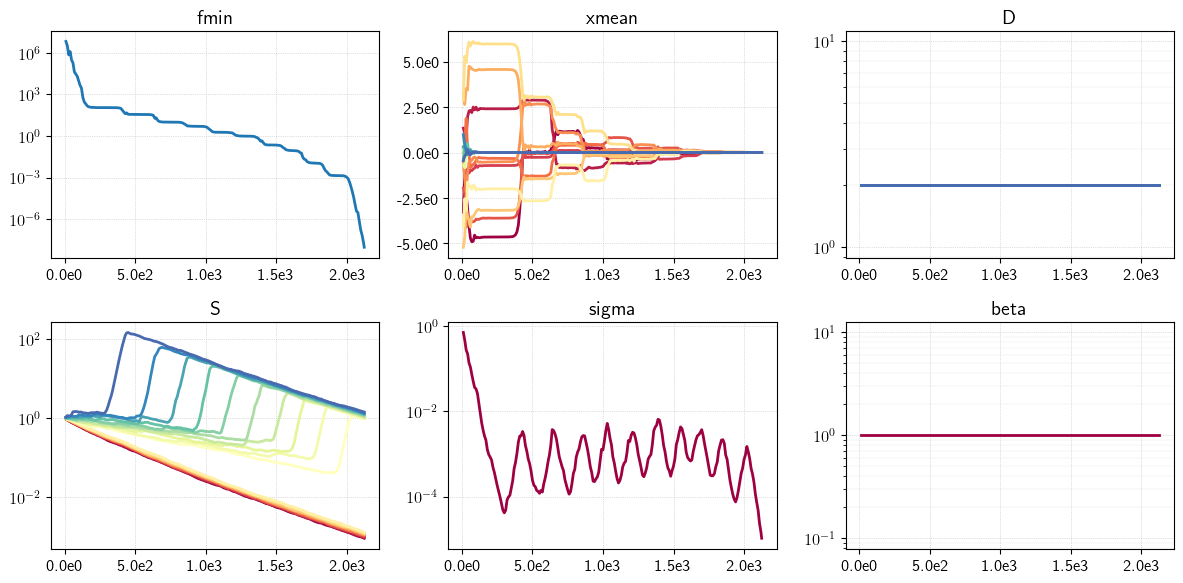

In [ ]:
N = 20

def fobj(x):
    k = x.shape[1] // 2
    f = np.sum(x[:, :k] ** 2, axis=1) + 1e6 * np.sum(x[:, k:] ** 2, axis=1)
    return f

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), 
              sigma0=np.ones(N)*2.,
              lam=None,
              flg_covariance_update=True,
              flg_variance_update=False,
              flg_active_update=False)
# ddcma.cone = 0  # without rank-one update
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### 挙動の比較

探索終了までに必要な評価回数だけでなく，振る舞いが大きく異なっていることが確認できる．この振る舞いの違いを理解することが，rank-one updateの動作原理を理解する上で重要である．

この関数のヘッセ行列は，$10^6$の固有値を$d/2$個，$1$の固有値を$d/2$個持つ．そのため，共分散行列も$d/2$個の固有値が残りの固有値よりも$10^6$倍大きなものとなっていることが確認できる．ただし，その学習過程において，
- Rank-$\mu$： 共分散行列の小さな固有値$d/2$個が同時に小さくなっていく．
- Rank-$\mu$+rank-one: 共分散行列の小さな固有値$d/2$個が同時に小さくなっていくとともに，大きな固有値が一つずつ他よりも高速に大きくなる．また，各固有値の増加の前に$\sigma$が減少し，固有値の増加が始まると$\sigma$も増加する，という振動が見られる．

固有値が一つずつ増加する現象は，rank-one updateの影響であることが容易に想像される．Rank-one update では，更新式に$p_C p_C^\mathrm{T} - C$が追加される．第二項は現在の共分散行列をスケールダウンする効果を持ち，固有値の比には影響しない．第一項はrank 1の行列（そのためrank-one updateと呼ばれる）であり，共分散行列の一次元分の成分を大きくする効果を持つ．当然，大きくなる方向は進化パスの方向に対応する．すなわち，特定の（目的関数に与える影響が鈍感な == ヘッセ行列の固有値が小さな == すなわち共分散行列の固有値が大きな）方向に進化パスが長くなっている．

この特定の方向は，概ね $- \sqrt{C} \nabla f (m)$ の方向に対応している．これは，以下のように説明される．
1. 正規分布$\mathcal{N}(m, \sigma^2 C)$を用いて目的関数$f(x)$を探索する（解をサンプリングする）ことは，$C = I$となるように変換した座標系$y = \sqrt{C}^{-1}x$のもとで正規分布$\mathcal{N}(\sqrt{C}^{-1} m, \sigma^2 I)$を用いて目的関数$\bar{f}(y) = f(\sqrt{C} y)$を探索することと等価である．
2. 変換後の座標系で考える．$\sigma$が十分に小さくなれば，平均ベクトル$\sqrt{C}^{-1}m$の近傍において目的関数値は一次近似$\bar{f}(y) \approx \bar{f}(\sqrt{C}^{-1}m) + \nabla \bar{f}(\sqrt{C}^{-1}m)^\mathrm{T} (y - \sqrt{C}^{-1}m)$を用いて良く近似される．すなわち，勾配が$\nabla \bar{f}(\sqrt{C}^{-1}m) = \sqrt{C} \nabla f f(\sqrt{C} (\sqrt{C}^{-1}m)) = \sqrt{C} \nabla f(m)$となる線形関数で近似される．
3. 線形関数であれば，ランキング上位の解は勾配と逆方向に大きな成分を持った解であることから，その加重和を取る進化パスはその方向に大きくなることが予想される．

共分散行列がヘッセ行列の逆行列を良く近似していない場合に$\sigma$が小さくなる理由は，CSAで用いている進化パスが大きくならないからである．ただし，共分散行列がヘッセ行列の逆行列を近似していない場合，そもそも最適な$\sigma$も小さくなるため，適切に振る舞うステップサイズ更新則が実装されていれば，CSAに限らずそのようになることが予想される．この部分に関しては，以下の文献などを参照されたい．

[5] Youhei Akimoto, Anne Auger, Nikolaus Hansen,
Quality gain analysis of the weighted recombination evolution strategy on general convex quadratic functions,
Theoretical Computer Science,
Volume 832,
2020,
Pages 42-67

[6] Daiki Morinaga, Kazuto Fukuchi, Jun Sakuma, Youhei Akimoto,
Convergence Rate of the (1+1)-Evolution Strategy with Success-Based Step-Size Adaptation on Convex Quadratic Functions,
IEEE Transactions on Evolutionary Computation (accepted, preprint available at arXiv:2103.01578)



## Active update

簡単のため，rank-$\mu$ updateのみを用いる更新式をベースラインとして考える．
上に見たように，$C$の更新式は
$$\begin{aligned}
C 
&\leftarrow C + c_\mu \sum_{i=1}^{\lambda} w_{i}\left( y_{i:\lambda}y_{i:\lambda}^\mathrm{T} - C \right) \\
&= \left(1 - c_\mu \sum_{i=1}^{\lambda} w_{i} \right) C + c_\mu \sum_{i=1}^{\lambda} w_{i} y_{i:\lambda}y_{i:\lambda}^\mathrm{T} \\
&= \left(1 - c_\mu \right) C + c_\mu \sum_{i=1}^{\lambda} w_{i} y_{i:\lambda}y_{i:\lambda}^\mathrm{T}
\end{aligned}
$$
となる．ここで，最右辺はrank-$\mu$ update を考える場合には$w_1 \geq \dots \geq w_\lambda \geq 0$であり$\sum_{i=1}^{\lambda} w_i = 1$となるような重みを仮定していたことを用いている．
しばしば用いられている推奨値は，$\mu = \lambda / 2$とし，$w_1 > \dots > w_\mu > 0$，$w_{\mu+1} = \dots w_{\lambda} = 0$となるような値である．

最右辺を見るとわかるように，共分散行列は学習率の影響で毎イテレーション$(1 - c_\mu)$倍スケールダウンし（第一項），選択された上位$\mu$個の解$y_{i:\lambda}$は全て$C$の成分を大きくするような影響を持つ．理解が難しければ，$C = I$で$\mu = 1$となるケースを考えてもらえば良い．このとき，更新後の$C$の固有値は$(1 - c_\mu) + c_\mu w_1 \|y_{1:\lambda}\|$と$(1 - c_\mu)$であり，最大固有値（前者）に対応する固有ベクトルは$y_{1:\lambda} / \|y_{1:\lambda}\|$であることから，解の情報は共分散の成分（固有値）を大きくするためにもちいられていることがわかる．
特定の方向に共分散行列を大きくすることは比較的容易であるが，特定の方向に共分散行列を小さくするためには，第一項の影響で小さくなるのを待ち，第二項の影響で小さくしたくない成分を補うように更新される必要がある．言い換えれば，一つの方向に対して共分散行列を小さくするためには，残り$d - 1$方向に対して共分散行列を大きくするように更新しなければならないのである．
なお，更新式からわかるように，rank-one updateも同じ効果を持つため，共分散行列の成分を積極的に小さくすることはできない．

Active update は，共分散行列の成分を積極的に小さくするための方法である．
実現方法は実に単純であり，目的関数値に基づくランキングが上位$\mu$に入らない解に対して負の重みを与えるというものである．ランキングが下位の解は目的関数の大きな領域に分布していることになるため，そのような方向へは共分散行列の成分を小さくしたい，というのは自然な発想である．仮に$w_1, \dots, w_\mu > 0$で総和が$1$，$w_{\mu+1}, \dots, w_\lambda < 0$で総和が$-1$であるような重みを設定した場合，上にみた更新式は
$$
C = C + c_\mu \sum_{i=1}^{\mu} w_{i} y_{i:\lambda}y_{i:\lambda}^\mathrm{T} - c_\mu \sum_{i=\mu+1}^{\lambda} |w_{i}| y_{i:\lambda}y_{i:\lambda}^\mathrm{T}
$$
と書き下すことができる．このとき，共分散行列が学習率の影響で自然に小さくなるという性質はなくなり，代わりにランキング下位の解の分布する方向に対して積極的に共分散行列の成分を小さくしていることがわかる．実装上は，共分散行列が正定値であることを保証する必要があるため，重みパラメータの決定方法に工夫がなされている．詳細は文献[1]を参照されたい．


#### 検証実験
２つの悪スケールな関数を用いて実験を行う．
Cigar 関数（$x_1$ が目的関数に与える影響が，それ以外の変数と比べて著しく小さな関数）
$$
f(x) = x_1^2 + 10^6 \sum_{i=2}^{d} x_i^2
$$
Tablet 関数（$x_1$ が目的関数に与える影響が，それ以外の変数と比べて著しく小さな関数）
$$
f(x) = 10^6 x_1^2 + \sum_{i=2}^{d} x_i^2
$$

検証項目
* Tablet 関数では，active updateにより共分散行列の成分を減少させる速さが加速され，active updateを用いない場合と比較して高速な探索が可能になる
* Cigar 関数では，active updateの有無によらない

10 120 31707756.92670651 31707756.92670651
20 240 10874668.593158212 10874668.593158212
30 360 2468031.212588576 2468031.212588576
40 480 1210227.9889798325 871773.4749899013
50 600 664247.209440292 663848.8815856434
60 720 224011.69726071417 184709.34835802898
70 840 86573.25403184858 86573.25403184858
80 960 26941.8042913545 26941.8042913545
90 1080 9663.32460308741 9663.32460308741
100 1200 3767.9261587759975 3167.020189445832
110 1320 1136.7632235552742 1136.7632235552742
120 1440 786.3879806377176 448.82316417201656
130 1560 147.3900298010591 147.3900298010591
140 1680 95.5316064749487 77.51202641162651
150 1800 13.874538523412077 13.874538523412077
160 1920 5.773843695592872 5.773843695592872
170 2040 2.9687299859479546 2.9662594941581664
180 2160 1.8094040167724046 1.5952992794073162
190 2280 1.344796028417529 1.2748336427626805
200 2400 1.121262764798598 1.104077298962787
210 2520 1.0583642584898096 1.0576544069419997
220 2640 1.0478964910486164 1.0478964910486164
230 2760 1.03

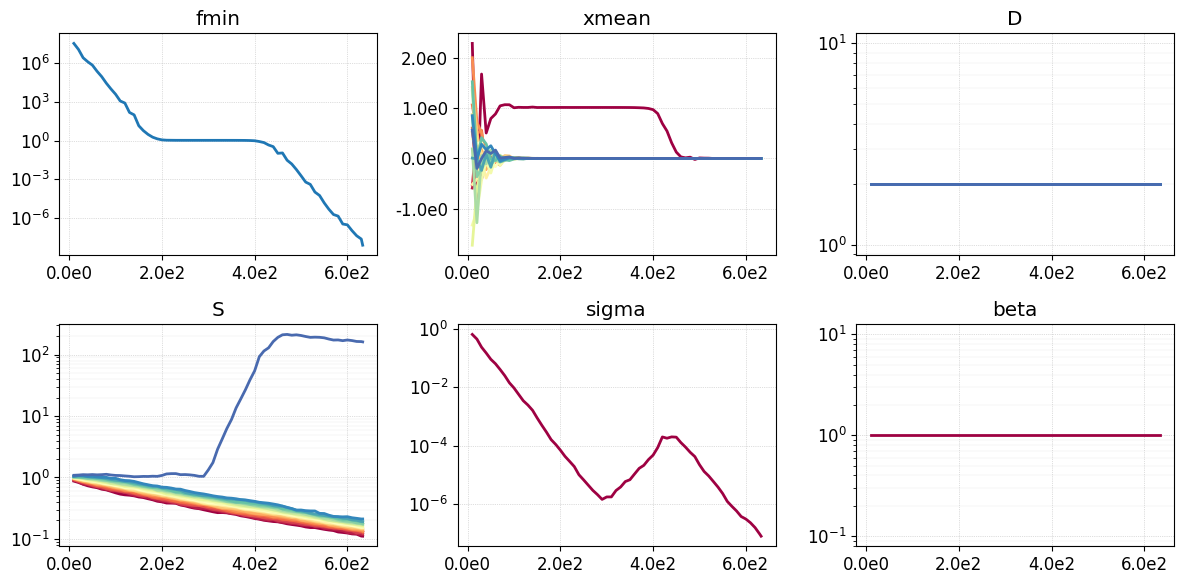

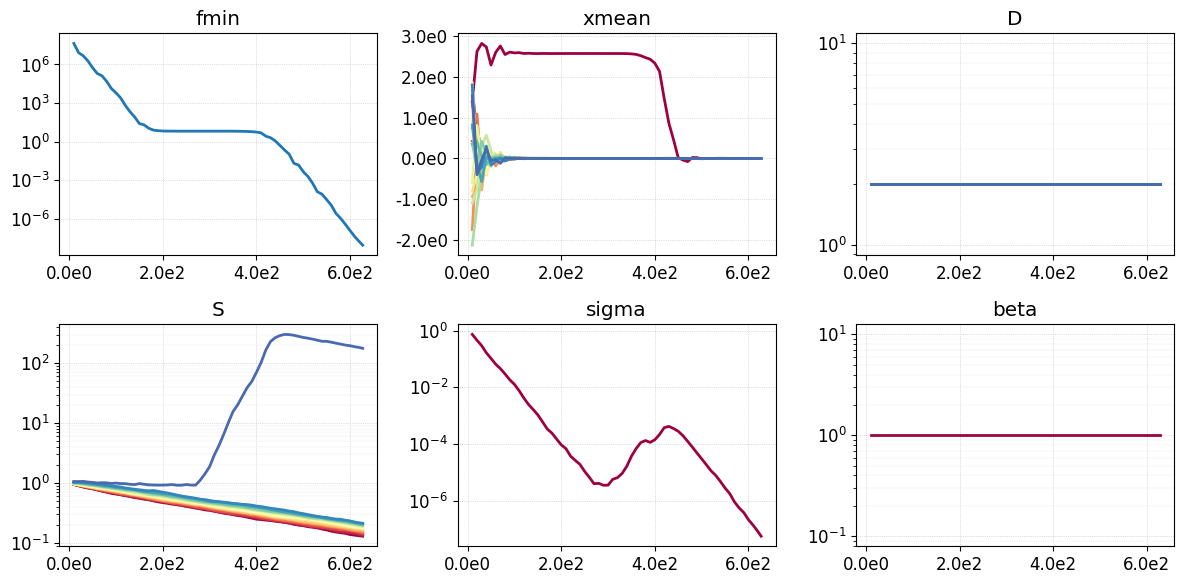

In [3]:
def cigar(x):
    return x[:, 0] ** 2 + 1e6 * np.sum(x[:, 1:] ** 2, axis=1)

def tablet(x):
    return 1e6 * x[:, 0] ** 2 + np.sum(x[:, 1:] ** 2, axis=1)

def fobj(x):
    return cigar(x)  # Cigar関数
    # return tablet(x)  # Tablet関数

N = 20

MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

for flg_active_update in [True, False]:
    # Main loop
    ddcma = DdCma(xmean0=np.random.randn(N), 
                  sigma0=np.ones(N)*2.,
                  lam=None,
                  flg_covariance_update=True,
                  flg_variance_update=False,
                  flg_active_update=flg_active_update)  # active update を利用する場合にはTrue
    checker = Checker(ddcma)
    logger = Logger(ddcma)

    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))

    # Produce a figure
    fig, axdict = logger.plot()
    for key in axdict:
        if key not in ('xmean'):
            axdict[key].set_yscale('log')
    plt.tight_layout()
    plt.savefig(logger.prefix + '.pdf')

## Diagonal Acceleration

Separable-CMA（$C = I$として＄D＄のみ更新する方法）とスタンダードなCMA（$D$を固定し$C$のみ更新する方法）を比較した場合，前者には２つの利点がある．

1. イテレーション毎の計算時間とメモリ使用量がいずれも次元数$d$に対して線形（スタンダードなCMAでは平均して二乗のオーダー）であるため，高次元の問題において内部の計算時間が問題になる場合には有効

2. $D$の学習率は$C$の学習率よりも大きく設定することが可能である．推奨値では前者が$1/d$に比例しているのに対し，後者は$1/d^2$に比例する．その結果，対角行列のみで十分な場合にはSeparable-CMAはスタンダードなCMAよりも高速に最適化が可能である．

ここでは２つ目の利点に着目する．１つ目の利点については別の機会に詳しく紹介する．

（更新中）